In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# PyTorch Example
import torch
print("Is CUDA available? ", torch.cuda.is_available())
print("GPU Device Name: ", torch.cuda.get_device_name(0))

2024-12-28 17:28:49.508237: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-28 17:28:49.749352: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-28 17:28:49.749420: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-28 17:28:49.750807: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-28 17:28:49.862261: I tensorflow/core/platform/cpu_feature_g

Num GPUs Available:  1
Is CUDA available?  True
GPU Device Name:  NVIDIA GeForce RTX 4060 Laptop GPU


In [ ]:
!pip install tensorflow-datasets

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Dropout, Input, Layer
from tensorflow.keras.metrics import BinaryAccuracy, FalseNegatives, FalsePositives, TrueNegatives, TruePositives, Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

2025-01-10 16:43:38.331320: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-10 16:43:38.694002: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-10 16:43:38.694087: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-10 16:43:38.695997: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 16:43:38.866489: I tensorflow/core/platform/cpu_feature_g

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

2025-01-10 16:43:45.845452: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-10 16:43:46.023954: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-10 16:43:46.023996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-10 16:43:46.028526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-10 16:43:46.028583: I tensorflow/compile

In [ ]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [ ]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

In [ ]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

**Visualisation**

In [ ]:
for image_batch, label_batch in train_dataset.take(1):
    print(image_batch.shape)  # Should be (batch_size, 224, 224, 3)

(103, 103, 3)


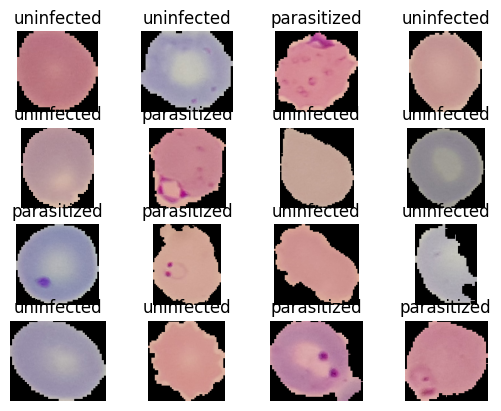

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)

  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
dataset_info.features['label'].int2str(1)

'uninfected'

# Data PreProcessing

In [ ]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE,IM_SIZE))/255.0, label

In [ ]:
train_dataset = train_dataset.map(resize_rescale)

In [ ]:
for image,label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
# Apply resizing and rescaling to all datasets
val_dataset = val_dataset.map(resize_rescale).batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(resize_rescale).batch(64).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Re-check train_dataset processing for consistency
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(64).prefetch(tf.data.AUTOTUNE)

# Model Creation

# Sequential API

In [ ]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(1000, activation="relu"),
    BatchNormalization(),
    Dense(100, activation="relu"),
    BatchNormalization(),
    Dense(1, activation="sigmoid"),
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 batch_normalization_48 (Ba  (None, 222, 222, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 111, 111, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 16)      2320      
                                                                 
 batch_normalization_49 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                     

# Functional API

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x= Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor_model = Model(func_input, output, name="Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      2320      
                                                                 
 batch_normalization_9 (Bat  (None, 109, 109, 16)

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

x = feature_extractor_model(func_input)

x=Flatten()(x)

x=Dense(1000, activation="relu")(x)
x=BatchNormalization()(x)
x=Dense(100, activation="relu")(x)
x=BatchNormalization()(x)
func_output=Dense(1, activation="sigmoid")(x)

model = Model(func_input, func_output, name="Lenlet_Model")
model.summary()

Model: "Lenlet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Functio  (None, 54, 54, 16)        2896      
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 1000)              46657000  
                                                                 
 batch_normalization_10 (Ba  (None, 1000)              4000      
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 100)              

# Finally doing it using seq and func

In [ ]:
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
])

feature_extractor_seq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 batch_normalization_12 (Ba  (None, 222, 222, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)      2320      
                                                                 
 batch_normalization_13 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                        

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

x = feature_extractor_seq_model(func_input)

x=Flatten()(x)

x=Dense(1000, activation="relu")(x)
x=BatchNormalization()(x)
x=Dense(100, activation="relu")(x)
x=BatchNormalization()(x)
func_output=Dense(1, activation="sigmoid")(x)

model = Model(func_input, func_output, name="Lenlet_Model")
model.summary()

Model: "Lenlet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 54, 54, 16)        2896      
                                                                 
 flatten_3 (Flatten)         (None, 46656)             0         
                                                                 
 dense_9 (Dense)             (None, 1000)              46657000  
                                                                 
 batch_normalization_14 (Ba  (None, 1000)              4000      
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            (None, 100)               100100    
                                                      

# Model Subclassing

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self,filters, kernel_size,strides,padding,activation,pool_size):
    super(FeatureExtractor, self).__init__()

    self.conv1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.bn1 = BatchNormalization()
    self.pool1 = MaxPool2D(pool_size = pool_size, strides=2*strides)

    self.conv2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.bn2 = BatchNormalization()
    self.pool2 = MaxPool2D(pool_size = pool_size, strides=2*strides)


  def call(self,x,training):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.pool2(x)

    return x

feature_sub_classed = FeatureExtractor(8, 3,1,"valid","relu",2)

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

x = feature_sub_classed(func_input)

x=Flatten()(x)

x=Dense(1000, activation="relu")(x)
x=BatchNormalization()(x)
x=Dense(100, activation="relu")(x)
x=BatchNormalization()(x)
func_output=Dense(1, activation="sigmoid")(x)

model = Model(func_input, func_output, name="Lenlet_Model")
model.summary()

Model: "Lenlet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 16)        1488      
 Extractor)                                                      
                                                                 
 flatten (Flatten)           (None, 46656)             0         
                                                                 
 dense (Dense)               (None, 1000)              46657000  
                                                                 
 batch_normalization_2 (Bat  (None, 1000)              4000      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)              

In [ ]:
class Model(tf.keras.Model):
  def __init__(self,filters, kernel_size,strides,padding,activation,pool_size):
    super(Model, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3,1,"valid","relu",2)

    self.flatten = Flatten()

    self.dense1 = Dense(100, activation="relu")
    self.bn1 = BatchNormalization()
    self.dense2 = Dense(10, activation="relu")
    self.bn2 = BatchNormalization()

    self.dense3 = Dense(1, activation="sigmoid")

  def call(self,x,training):
    x = self.feature_extractor(x)

    x = self.flatten(x)

    x = self.dense1(x)
    x = self.bn1(x)
    x = self.dense2(x)
    x = self.bn2(x)
    x = self.dense3(x)

    return x

model_sub_classed = Model(filters=8,
    kernel_size=3,
    strides=1,
    padding="valid",
    activation="relu",
    pool_size=2)
model_sub_classed(tf.zeros((1, 224, 224, 3)))
model_sub_classed.summary()

2025-01-10 16:44:13.640724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_6 (Bat  multiple                  400       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             multiple                  1010      
                                                                 
 batch_normalization_7 (Bat  multiple                  40    

# Custom Layers

In [ ]:
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape= (input_features_shape[-1],self.output_units),initializer="random_normal",trainable=True)
    self.b = self.add_weight(shape= (self.output_units,),initializer="random_normal",trainable=True)

  def call(self,input_features):

    pre_output = tf.matmul(input_features,self.w) + self.b

    if(self.activation == "relu"):
      return tf.nn.relu(pre_output)
    elif(self.activation == "sigmoid"):
      return tf.math.sigmoid(pre_output)
    else:
      return pre_output

In [ ]:
custom_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    NeuralearnDense(1000, activation="relu"),
    BatchNormalization(),
    NeuralearnDense(100, activation="relu"),
    BatchNormalization(),
    NeuralearnDense(1, activation="sigmoid"),
])

custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      2320      
                                                                 
 batch_normalization_9 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

# Callback

In [ ]:
class LossCallback(Callback):
  def on_epoch_end(epoch, self, logs):
    print("\n For Epoch no {} model loss = {}".format(epoch, logs["loss"]))

  # def on_batch_end(self, batch, logs):
  #   print("\n For Batch no {} model loss = {}".format(batch, logs)


  # def __init__(self, threshold):
  #   super(LossCallback, self).__init__()
  #   self.threshold = threshold


  # You can also log all things in a csv logger see TF documentation

# Early Stopping (For Overfitting)

In [ ]:
es_callback = EarlyStopping(
    monitor = 'val_loss', min_delta = 0.001, patience = 3, verbose = 1, mode = 'auto', restore_best_weights = True
)

# Learning Rate Scheduling

In [ ]:
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

# There are also diffrent types of learning rate schedulers online go look em and find the best one
scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

You can use model checkpointing to save models in between at diffrent parts of training process

You can also reduce LR on plateou

# Model Training

In [ ]:
y_true = [0,1,0,0]
y_pred = [0.6,0.51,0.94,1]
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true,y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9340706>

In [ ]:
tf.debugging.set_log_device_placement(True)

In [ ]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'),Precision(name='precision'), Recall(name='recall'),AUC(name='auc')]

In [ ]:
# Compile and fit the model
custom_model.compile(optimizer=Adam(learning_rate=0.01), loss=BinaryCrossentropy(), metrics=metrics)

In [ ]:
print(tf.__version__)

2.14.0


In [ ]:
history = custom_model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1, callbacks = [LossCallback() , es_callback, scheduler_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/100
  6/345 [..............................] - ETA: 18s - loss: 0.0546 - tp: 201.0000 - fp: 1.0000 - tn: 177.0000 - fn: 5.0000 - accuracy: 0.9844 - precision: 0.9950 - recall: 0.9757 - auc: 0.9967WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0238s vs `on_train_batch_end` time: 0.0247s). Check your callbacks.


345/345 [==============================] - ETA: 0s - loss: 0.0608 - tp: 10841.0000 - fp: 277.0000 - tn: 10747.0000 - fn: 181.0000 - accuracy: 0.9792 - precision: 0.9751 - recall: 0.9836 - auc: 0.9967
 For Epoch no <__main__.LossCallback object at 0x7f5d7c5570d0> model loss = 0.060803983360528946
345/345 [==============================] - 23s 59ms/step - loss: 0.0608 - tp: 10841.0000 - fp: 277.0000 - tn: 10747.0000 - fn: 181.0000 - accuracy: 0.9792 - precision: 0.9751 - recall: 0.9836 - auc: 0.9967 - val_loss: 0.8996 - val_tp: 585.0000 - val_fp: 48.0000 - val_tn: 1308.0000 - val_fn: 814.0000 - val_accuracy: 0.6871 - val_precision: 0.9242 - val_recall: 0.4182 - val_auc: 0.9287 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/100
345/345 [==============================] - ETA: 0s - loss: 0.0549 - tp: 10835.0000 - fp: 258.0000 - tn: 10759.0000 - fn: 194.0000 - accuracy: 0.9795 - precision: 0.9767 - recall: 0.9824 - auc: 0.9976
 For Epoch n

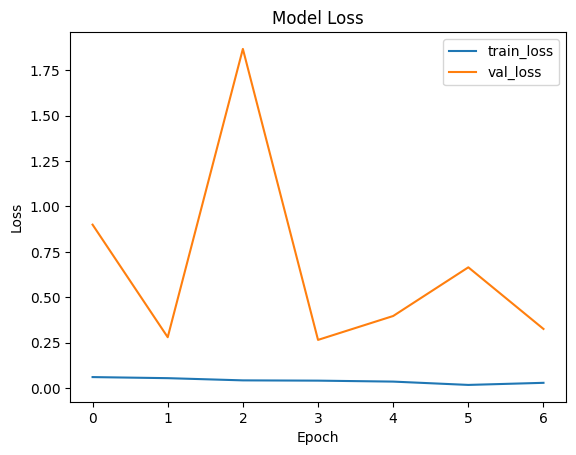

In [ ]:
 plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

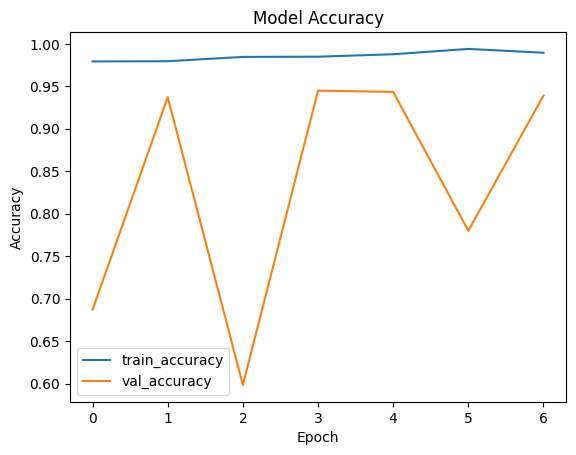

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and testing

In [ ]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
custom_model.evaluate(test_dataset)

44/44 [==============================] - 2s 20ms/step - loss: 0.3183 - tp: 1290.0000 - fp: 107.0000 - tn: 1293.0000 - fn: 67.0000 - accuracy: 0.9369 - precision: 0.9234 - recall: 0.9506 - auc: 0.9709


[0.3183250427246094,
 1290.0,
 107.0,
 1293.0,
 67.0,
 0.9368879199028015,
 0.9234073162078857,
 0.9506263732910156,
 0.9708988666534424]

# Visualising Confusion Matrix

In [ ]:
labels = []
inp = []

for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [ ]:
print(np.array(inp).shape)
print(np.array(inp)[0].shape)

(44,)
(64, 224, 224, 3)


/tmp/ipykernel_394/1921654648.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(inp).shape)
/tmp/ipykernel_394/1921654648.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(inp)[0].shape)


In [ ]:
print(labels)
# labels = np.array([i[0] for i in labels])

[array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1]), array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0]), array([1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]), array([1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]), array([0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,

In [ ]:
predicted = custom_model.predict(np.array(inp)[0])
print(predicted[:,0])

/tmp/ipykernel_394/2401406990.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predicted = custom_model.predict(np.array(inp)[0])


2/2 [==============================] - 1s 8ms/step
[8.61666747e-04 3.78693687e-04 9.99990106e-01 9.88495708e-01
 1.68443730e-05 9.20908988e-01 9.99163389e-01 9.99851704e-01
 9.90519404e-01 1.00000000e+00 9.99994516e-01 9.38244193e-05
 1.16124138e-05 9.97060716e-01 9.99519229e-01 6.69587264e-03
 1.00000000e+00 6.02367818e-01 2.24052882e-03 9.80607271e-01
 2.33615137e-04 2.72301257e-01 2.62173307e-05 4.91518863e-02
 4.97280795e-04 9.99693990e-01 9.46459535e-04 9.82443988e-01
 3.47152672e-05 1.00000000e+00 9.99992967e-01 2.38180874e-05
 9.99710143e-01 1.00000000e+00 5.41092966e-08 1.25034958e-05
 9.28769857e-02 9.99999642e-01 1.00000000e+00 9.97969806e-01
 9.87866044e-01 1.00000000e+00 5.92920551e-05 9.99999523e-01
 9.99985218e-01 1.32675245e-01 4.84194170e-04 9.99958038e-01
 8.74050776e-04 9.89245534e-01 1.96474488e-04 1.00000000e+00
 4.79738781e-04 9.93203759e-01 3.63772939e-04 9.86521602e-01
 1.36363515e-05 9.99925494e-01 1.00000000e+00 7.29982930e-05
 9.99420762e-01 3.00580905e-05 1.9

In [ ]:
# Ensure both arrays have the same length
min_len = min(len(labels), len(predicted))
labels = labels[:min_len]
predicted = predicted[:min_len]

In [ ]:
predicted = (predicted > 0.3).astype(int)

In [ ]:
cm = confusion_matrix(labels, predicted)
print(cm)

plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix - {}'.format(threshold))
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
threshold = 0.5

cm = confusion_matrix(labels,predicted>threshold)
print(cm)

plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix - {}'.format(threshold))
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Roc Plots

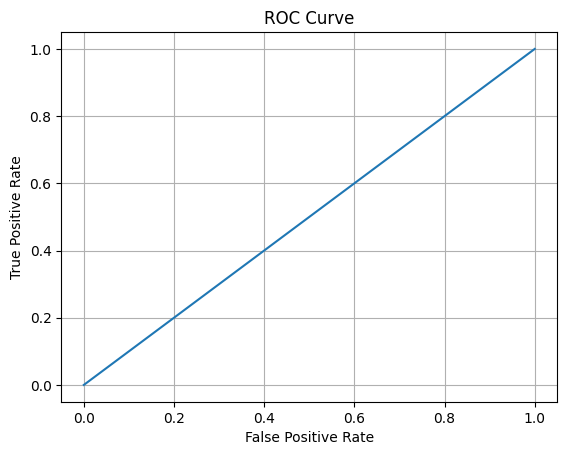

In [ ]:
fp,tp,threshold = roc_curve(labels,predicted)

plt.plot(fp,tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

plt.grid()
plt.show()

Stuff

In [ ]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

2/2 [==============================] - 0s 9ms/step


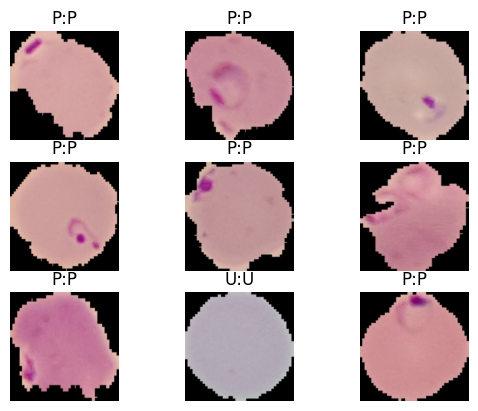

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)

  plt.imshow(image[0])
  plt.title(
    str(parasite_or_not(label.numpy()[0]))
    + ":"
    + str(parasite_or_not(model.predict(image)[0][0]))
  )
  plt.axis('off')